In [2]:
# goal : create word vectors from 'Game of Thrones' books dataset
# and analyze them to see semantic similarity

# __future__ library bridges the link btw Python2 and Python3 ( not needed )
from __future__ import absolute_import, division, print_function
# for word encoding
import codecs
# regex, glob
import re
import glob
# parallel programming
import multiprocessing
# dealing  with operation systems like reading a file
import os
# pretty printing, human readable
import pprint
# natural language processing toolkit
import nltk 
# word 2 vec
import gensim.models.word2vec as w2v
# dimensionality reduction
import sklearn.manifold
import numpy as np
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


C:\Users\Tarunbir Singh\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Step 1 : Process our data
# Clean our data
nltk.download('punkt')  # pretrained tokenizer
nltk.download('stopwords')  # list of unecessary words

[nltk_data] Downloading package punkt to C:\Users\Tarunbir
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Tarunbir
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Get the book names, matching txt file
book_filenames = sorted(glob.glob("*.txt"))
book_filenames

['got1.txt', 'got2.txt', 'got3.txt', 'got4.txt', 'got5.txt']

In [6]:
# Combine the books into one string
corpus_raw = 'u'   # u -> unicode string
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
# converting to utf-8 format
    with codecs.open(book_filename,"r","utf-8") as book_file:   
        corpus_raw  += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw))) 
    print()

Reading 'got1.txt'...
Corpus is now 1770659 characters long

Reading 'got2.txt'...
Corpus is now 4071041 characters long

Reading 'got3.txt'...
Corpus is now 6391405 characters long

Reading 'got4.txt'...
Corpus is now 8107945 characters long

Reading 'got5.txt'...
Corpus is now 9719485 characters long



In [7]:
# Split the Corpus into sentences (punkt same as sent_tokenize)
tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")

In [8]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [9]:
# convert into list of words
# remove unecessary, split into words, no hyphens
# list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ",raw)   
    words = clean.split()
    return words

In [10]:
# sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [11]:
print(raw_sentences[3])
#print(re.sub("[^a-zA-Z]"," ",raw_sentences[3]))
print(sentences[3])   # list after applying 'sentence_to_wordlist

Copyright © 1999 by George R. R. Martin.
['Copyright', 'by', 'George', 'R', 'R', 'Martin']


In [12]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens.".format(token_count))  
# :, for comma

The book corpus contains 1,818,103 tokens.


In [13]:
# Train Word2Vec

# Once we have vectors : Build Model
# main task that vectors help with
# DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors
# ( The more dimensions, more computationally expensive, but more accurate )
num_features = 300

# Minimun word count threshold
min_word_count = 3

# Number of threads to run in parallel
# more workers, faster we train
# setting it equal to the number of CPU-Cores present
num_workers = multiprocessing.cpu_count() 

# context window length
# window size for looking at words
context_size = 7

# Downsample setting for frequent words
# we want to use less frequent words ( other than a, the, and etc )
# 0 - 1e-5 is generally good 
downsampling = 1e-3

# Seed for the randomization, making results reproducible
seed = 1

In [14]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [15]:
thrones2vec.build_vocab(sentences)

In [16]:
print("Word2Vec vocabulary length: ", len(thrones2vec.wv.vocab))

Word2Vec vocabulary length:  17277


In [17]:
# Start Training 
thrones2vec.train(sentences, total_examples=len(sentences), epochs=10)

(14043292, 18181030)

In [18]:
# Save to file, can be loaded later
if not os.path.exists("trained"):
    os.makedirs("trained")

In [19]:
thrones2vec.save(os.path.join("trained","thrones2vec.w2v"))

In [20]:
# Exploring the trained model
thrones2vec = w2v.Word2Vec.load(os.path.join("trained","thrones2vec.w2v"))

In [21]:
thrones2vec.wv.similar_by_word("she",topn=15)

[('he', 0.620920717716217),
 ('She', 0.5885067582130432),
 ('exulting', 0.5801353454589844),
 ('Hazzea', 0.579559326171875),
 ('reassure', 0.5771913528442383),
 ('accusers', 0.5612982511520386),
 ('Rule', 0.5549533367156982),
 ('soundly', 0.553852915763855),
 ('apprehensive', 0.5525684952735901),
 ('Bump', 0.5491390228271484),
 ('Timoth', 0.5483043193817139),
 ('appalled', 0.5452043414115906),
 ('glumly', 0.5450667142868042),
 ('Plainly', 0.5417758226394653),
 ('Brella', 0.5396022200584412)]

In [22]:
thrones2vec.wv.similarity("Sam","Sansa")   # Computes the cosine similarity

0.26755053

In [23]:
# Compress the word vectors into 2D space and plot them
# t-sne representation -> t-distributed stochastic neighbour embedding
# reduces the dimentionality like pca

tsne = sklearn.manifold.TSNE(n_components=2,random_state=0)

In [24]:
all_word_vectors_matrix = thrones2vec.wv.vectors

In [25]:
# Training the TSNE .... take a while
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)


In [26]:
# Plot the picture

points = pd.DataFrame(
    [(word, coords[0], coords[1])
        for word,coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
                for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word","x","y"]
)

In [27]:
points.head(10)

,word,x,y
0,This,7.752906,-23.756744
1,edition,-57.705463,-3.438488
2,the,-18.764542,11.293269
3,complete,-15.711406,-12.273027
4,of,3.761218,3.882189
5,original,-22.466442,-8.948515
6,hardcover,-56.882290,-3.048048
7,ONE,-51.969845,-14.115683
8,A,37.641068,-29.733358
9,OF,-59.633888,-9.599010


In [28]:
sns.set_context("poster")

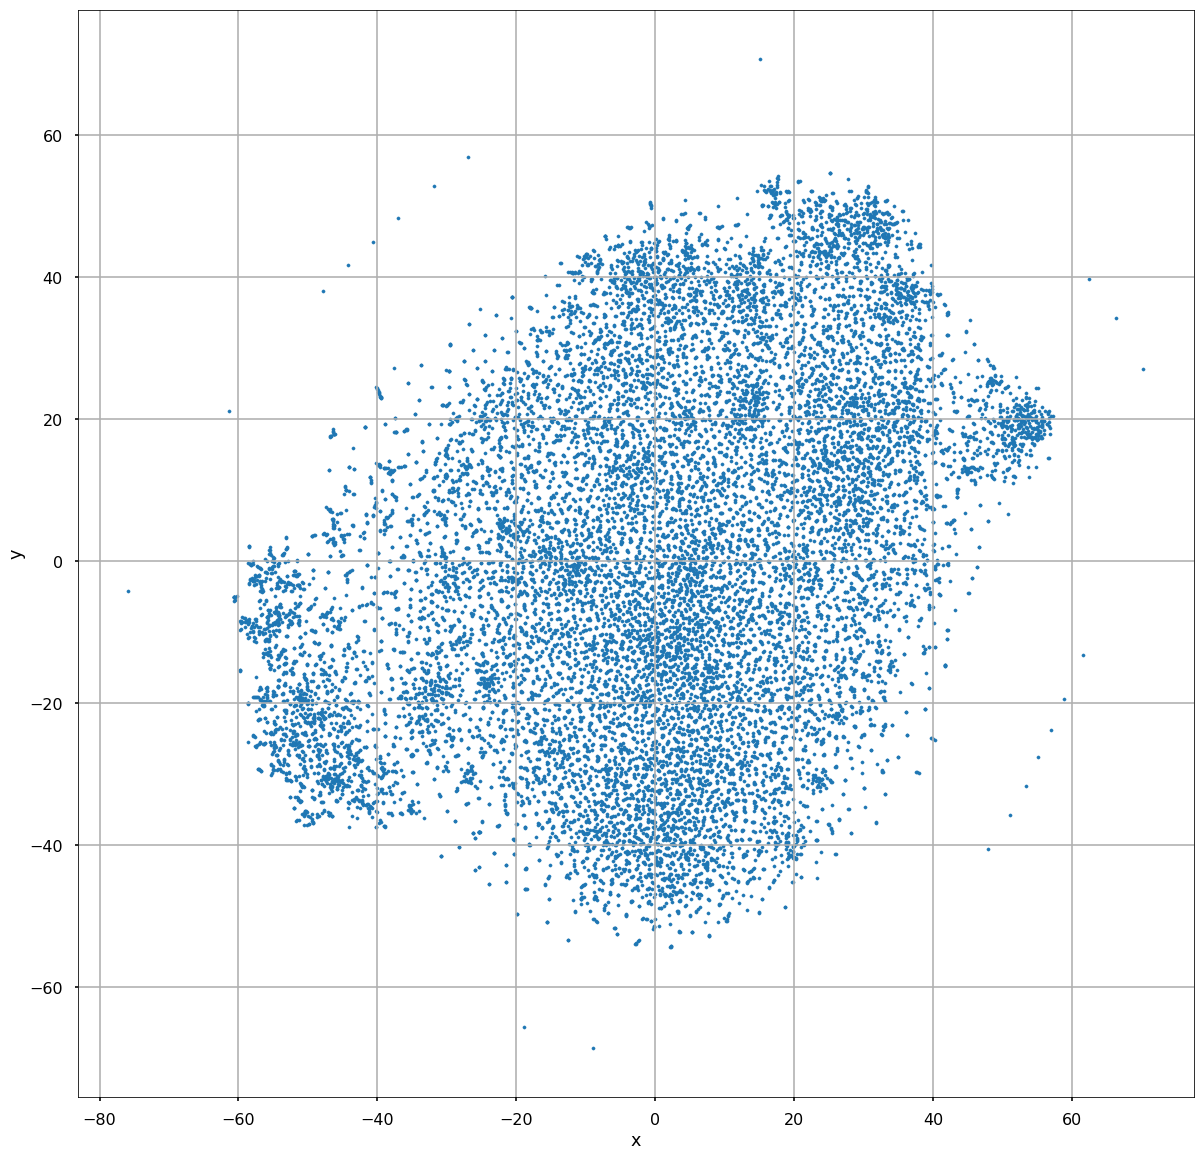

In [29]:
points.plot.scatter("x","y", s=10, figsize=(20, 20))
plt.grid()

In [30]:
# Zooming in to interesting places
# thsi function will give image in provided bounds

def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i,point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

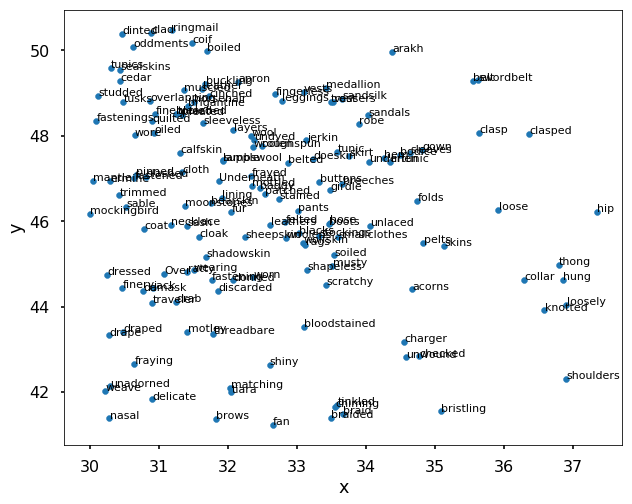

In [31]:
plot_region(x_bounds=(30.0,37.5), y_bounds=(41.1, 50.5))

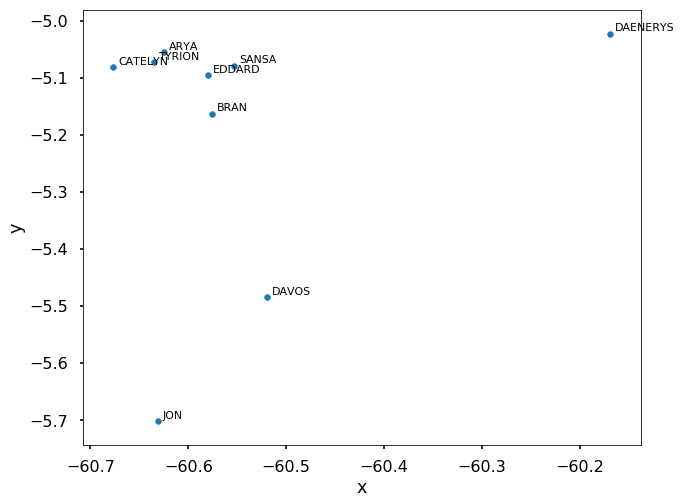

In [32]:
plot_region(x_bounds=(-65,-60), y_bounds=(-6,-1))

In [33]:
# Explore semantic similarities between Book Characters
# words closest to given word -> Cosine Similarity

thrones2vec.wv.most_similar("Arya")

[('Gendry', 0.5143522024154663),
 ('Horseface', 0.5118140578269958),
 ('Lumpyhead', 0.5081565976142883),
 ('Underfoot', 0.4904489517211914),
 ('exulting', 0.4838610887527466),
 ('sullenly', 0.47987431287765503),
 ('guiltily', 0.47629451751708984),
 ('horrible', 0.4745781421661377),
 ('she', 0.4726890027523041),
 ('anybody', 0.4719642996788025)]

In [34]:
thrones2vec.wv.most_similar("Stark")

[('Eddard', 0.6418435573577881),
 ('executed', 0.5191081166267395),
 ('beheaded', 0.4876478314399719),
 ('graces', 0.48642250895500183),
 ('Harlon', 0.47828805446624756),
 ('Lyanna', 0.4775421917438507),
 ('Horseface', 0.4733074903488159),
 ('ROSLIN', 0.4731893539428711),
 ('charmed', 0.47289368510246277),
 ('divulge', 0.47203773260116577)]

In [35]:
thrones2vec.wv.most_similar("blood")

[('Blood', 0.5510286688804626),
 ('veins', 0.5038043260574341),
 ('flows', 0.4566164016723633),
 ('bile', 0.44957804679870605),
 ('sap', 0.4475386440753937),
 ('excrement', 0.4421845078468323),
 ('trickled', 0.44194334745407104),
 ('stain', 0.4365898370742798),
 ('smeared', 0.43647125363349915),
 ('juice', 0.4332435131072998)]

In [36]:
thrones2vec.wv.most_similar_cosmul(positive=["Jaime","wine"],negative=["sword"])

[('sipped', 0.8726014494895935),
 ('drank', 0.8720934987068176),
 ('strongwine', 0.8697919249534607),
 ('hippocras', 0.8678269982337952),
 ('mulled', 0.8671576976776123),
 ('cup', 0.8532983064651489),
 ('tea', 0.850708544254303),
 ('fermented', 0.8465787768363953),
 ('refilled', 0.8454185128211975),
 ('sipping', 0.8431256413459778)]

In [37]:
# Linear relationships bewtween word pairs
def nearest_similarity_cosmul(start1,end1,end2):
    similarities = thrones2vec.wv.most_similar_cosmul(
        positive=[start1,end2],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [38]:
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")
nearest_similarity_cosmul("Arya", "Nymeria", "dragons")
nearest_similarity_cosmul("Jaime", "sword", "wine")

Stark is related to Winterfell, as Tully is related to Riverrun
Arya is related to Nymeria, as prophecies is related to dragons
Jaime is related to sword, as sipped is related to wine


'sipped'